In [ ]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

# 1. Load Pre-trained Model (available publicly on Hugging Face
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

/Users/ahmedhanif/miniconda3/envs/demo_selected/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ahmedhanif/miniconda3/envs/demo_selected/lib/python3.11/site-packages/torch/nn/modules/module.py:2586: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  module._load_from_state_dict(
/Users/ahmedhanif/miniconda3/envs/demo_selected/lib/python3.11/site-packages/torch/nn/modules/batchnorm.py:133: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assig

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)


In [4]:
# image = Image.open("1.jpeg")
image = Image.open("4.jpg")

In [5]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

In [6]:
THRESHOLD = 0.7

/Users/ahmedhanif/miniconda3/envs/demo_selected/lib/python3.11/site-packages/torch/nn/modules/module.py:2586: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  module._load_from_state_dict(
/Users/ahmedhanif/miniconda3/envs/demo_selected/lib/python3.11/site-packages/torch/nn/modules/batchnorm.py:133: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  super()._load_from_state_dict(
/Users/ahmedhanif/miniconda3/envs/demo_selected/lib/python3.11/site-packages/torch/nn/modules/batchnorm.py:133: UserWarning: 

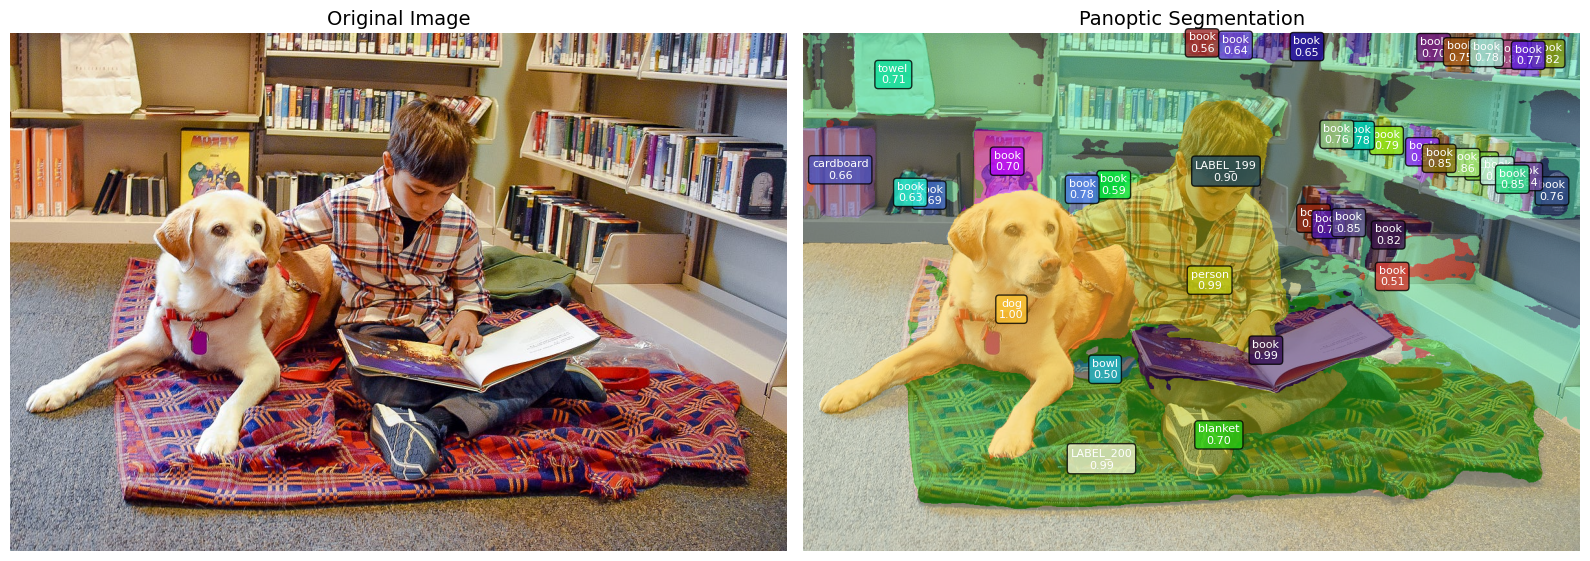

In [ ]:
import requests
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import DetrForSegmentation, DetrImageProcessor

# Load model and processor for segmentation
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

# Preprocess the image
inputs = processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)

target_sizes = [(image.height, image.width)]
result = processor.post_process_panoptic_segmentation(outputs, target_sizes=target_sizes)[0]

panoptic_seg = result["segmentation"]
segments_info = result["segments_info"]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(image)
axes[0].set_title("Original Image", fontsize=14)
axes[0].axis('off')

panoptic_seg_np = panoptic_seg.cpu().numpy()

np.random.seed(42)
colors = np.random.rand(panoptic_seg_np.max() + 1, 3)

colored_mask = colors[panoptic_seg_np]

image_np = np.array(image) / 255.0
alpha = 0.5
overlay = image_np * (1 - alpha) + colored_mask * alpha

axes[1].imshow(overlay)
axes[1].set_title("Panoptic Segmentation", fontsize=14)
axes[1].axis('off')

for seg in segments_info:
    seg_id = seg["id"]
    label_id = seg["label_id"]
    label_name = model.config.id2label.get(label_id, f"class_{label_id}")
    score = seg.get("score", 1.0)
    
    mask = panoptic_seg_np == seg_id
    if mask.any():
        y_coords, x_coords = np.where(mask)
        center_x = x_coords.mean()
        center_y = y_coords.mean()
        
        axes[1].text(center_x, center_y, f"{label_name}\n{score:.2f}", 
                     fontsize=8, color='white', ha='center', va='center',
                     bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[seg_id], alpha=0.8))

plt.tight_layout()
plt.savefig("./detr_panoptic.png", dpi=150, bbox_inches='tight')
plt.show()

# RCNN

In [14]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
# Load pre-trained Faster R-CNN
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
traditional_model = fasterrcnn_resnet50_fpn_v2(weights=weights)
traditional_model.eval()
# Get the category labels
categories = weights.meta["categories"]
print(f"Loaded Faster R-CNN with {len(categories)} classes")

Loaded Faster R-CNN with 91 classes


In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor()
])
image_tensor = transform(image).unsqueeze(0)  
# Run inference
with torch.no_grad():
    predictions = traditional_model(image_tensor)
# Get predictions
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']
print(f"Raw predictions BEFORE filtering: {len(boxes)} boxes")

Raw predictions BEFORE filtering: 100 boxes


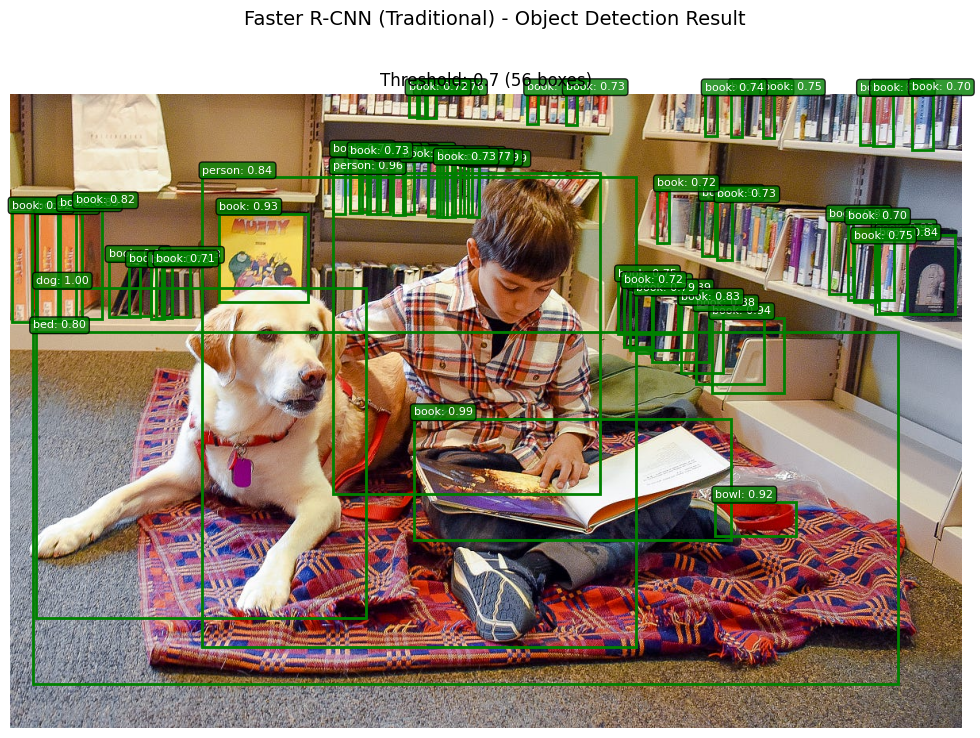

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define your single threshold here
threshold = THRESHOLD

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(image)

# Filter by the single threshold
mask = scores > threshold
filtered_boxes = boxes[mask]
filtered_labels = labels[mask]
filtered_scores = scores[mask]

for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
    x1, y1, x2, y2 = box.tolist()
    width, height = x2 - x1, y2 - y1
    
    # Draw bounding box
    rect = patches.Rectangle((x1, y1), width, height, 
                               linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    
    # Draw label and score
    ax.text(x1, y1 - 5, f"{categories[label]}: {score:.2f}", 
            fontsize=8, color='white', 
            bbox=dict(boxstyle="round", facecolor='green', alpha=0.8))

ax.set_title(f"Threshold: {threshold} ({len(filtered_boxes)} boxes)")
ax.axis('off')

plt.suptitle("Faster R-CNN (Traditional) - Object Detection Result", fontsize=14)
plt.tight_layout()
plt.savefig("./rcnn.png")
plt.show()